# Waterbodies visualisation

In this notebook we create a time-series visualisation of waterbodies.

## Setup

In [1]:
%config IPython.use_jedi = False

### Load modules

In [2]:
from pathlib import Path
import time

import IPython.display
import ipywidgets as ipyw
import numpy as np
import matplotlib.animation
import matplotlib.cm
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import scipy.spatial.distance
import scipy.ndimage
import sklearn.cluster
import sklearn.decomposition
from tqdm.notebook import tqdm
import traitlets

In [3]:
import plotly

### Load data

In [4]:
waterbody_shp_path = Path('/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/AusAllTime01-005HybridWaterbodies/AusWaterBodiesFINAL.shp')
waterbody_csv_path = Path('/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/timeseries_aus_uid/')
surface_area_threshold = 50

In [5]:
waterbody_shapes = gpd.read_file(waterbody_shp_path)

Choose an area of interest to focus on.

In [6]:
bbox = gpd.GeoDataFrame(geometry=gpd.points_from_xy((142.1246, 149.1300), (-37.0161, -34.2801)))  # Mildura -> Canberra, Seymour -> Griffith

In [7]:
bbox.crs = 'EPSG:4326'

In [8]:
x_min, y_min, x_max, y_max = bbox.to_crs('EPSG:3577').total_bounds

In [9]:
waterbody_shapes_ = waterbody_shapes.cx[x_min:x_max, y_min:y_max]

In [10]:
print(len(waterbody_shapes), 'waterbodies total')
print(len(waterbody_shapes_), 'in Mildura/Seymour/Canberra/Griffith area')

295906 waterbodies total
12535 in Mildura/Seymour/Canberra/Griffith area


In [11]:
waterbody_shapes = waterbody_shapes_

In [12]:
all_time_series = []
for i, shape in tqdm(waterbody_shapes.iterrows(), total=len(waterbody_shapes)):
    uid = shape.UID
    csv_path = waterbody_csv_path / uid[:4] / f'{uid}.csv'
    time_series = pd.read_csv(csv_path)
    # Relabel the third column to something consistent, and rename all columns to something
    # easier to access.
    time_series.rename(columns={
        'Observation Date': 'date',
        'Wet pixel percentage': 'pc_wet',
        time_series.columns[2]: 'px_wet',
        }, inplace=True)
    # Convert time strings into datetimes.
    time_series.date = pd.to_datetime(time_series.date)
    # Store the actual number of pixels too.
    n_pixels = shape.geometry.area // (25 ** 2)
    time_series.attrs['px_tot'] = n_pixels  # attrs is experimental.
    all_time_series.append(time_series)

In [13]:
waterbodies = waterbody_shapes.set_index('UID')

In [14]:
assert len(all_time_series) == len(waterbody_shapes)

It would be useful to remove entries with NaN water levels (presumably cloud or similar).

In [15]:
all_time_series_ = []
for t in tqdm(all_time_series):
    nans = t.px_wet.isnull()
    t = t[~nans].reset_index(drop=True)
    all_time_series_.append(t)

In [16]:
all_time_series = all_time_series_

In [17]:
waterbodies['water_history'] = all_time_series

Interpolate to a common grid.

In [18]:
dates = set()
for waterbody in tqdm(waterbodies.water_history):
    dates |= set(waterbody.date.values)

In [19]:
min_date, max_date = min(dates).astype('datetime64[D]'), max(dates).astype('datetime64[D]')

In [20]:
date_range = np.arange(min_date, max_date)

In [21]:
print('unique dates, day-rounded:', len(date_range))

unique dates, day-rounded: 12389


For each water history we can add in all these dates.

In [22]:
# First round every date and set date to be the index.
# Note that we also have to drop the timezone, which pandas assumes is UTC.
# If pandas did not assume it was UTC - maybe it assumed UTC+11 for example - then this would also do
# a conversion into UTC, which is probably not what we want.
for history in tqdm(waterbodies.water_history):
    history.date = history.date.dt.round('1d')
    history.set_index('date', drop=True, inplace=True)
    history.index = history.index.tz_convert(None)

In [23]:
dt_index = pd.DatetimeIndex(date_range)

In [24]:
histories = []  # Storing reindexed dataframes back directly in waterbodies leads to some super bizarre behaviour where they are replaced entirely by nans.
# So, storing them in a list instead.
for i in tqdm(range(len(waterbodies))):
    # Merge duplicate dates into one.
    history = waterbodies.water_history[i].groupby('date').mean()
    # Then reindex with the full list of dates.
    histories.append(history.reindex(dt_index))

In [25]:
waterbodies.water_history = histories

With all the water histories now having the same time index, they are all aligned. We now need to handle the lack of measurements at some times, and we will do this by linear interpolation as it is the least information thing we can do (besides setting them to the last observed value, which feels unphysical).

In [26]:
for history in tqdm(waterbodies.water_history):
    history.interpolate(limit_direction='both', inplace=True)

Make a matrix for fast accessing for visualisation.

In [27]:
history_matrix = np.zeros((len(waterbodies), len(dt_index)))

for i, history in tqdm(enumerate(waterbodies.water_history)):
    history_matrix[i] = history.pc_wet

In [28]:
history_matrix_absolute = np.zeros((len(waterbodies), len(dt_index)))

for i, history in tqdm(enumerate(waterbodies.water_history)):
    history_matrix_absolute[i] = history.px_wet

## Visualisation 1: Time vs Area

Let's plot the times vs the areas and see if there are any obvious trends.

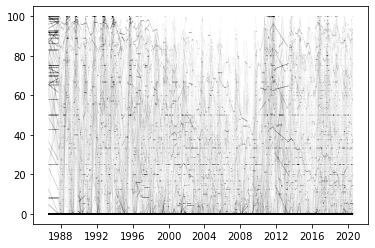

In [29]:
plt.figure()
for i in range(100):
    plt.scatter(dt_index, history_matrix[i], c='k', s=1, alpha=0.01, edgecolor='None')

This is, of course, unreadable. :)

## Visualisation 2: Area animation

In [30]:
%matplotlib widget

In [31]:
def plot_init(ax, subsample=10, t=0):
    total_areas = waterbodies.area[::subsample]
    px_wet = history_matrix_absolute[::subsample, t]
    pc_wet = history_matrix[::subsample, t]
    sc = ax.scatter(total_areas, pc_wet, c='k', s=px_wet / 1e2)
    ax.set_xscale('log')
    text = ax.text(0.05, 1.05, np.datetime_as_string(dt_index[t].to_numpy(), unit='D'), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    ax.set_xlabel('Maximum extent (px)')
    ax.set_ylabel('Wet percentage')
    return sc, text

In [32]:
def plot_update(ax, sc, text, t, subsample=10):
    total_areas = waterbodies.area[::subsample]
    px_wet = history_matrix_absolute[::subsample, t]
    pc_wet = history_matrix[::subsample, t]
    sc.set_offsets(np.stack([total_areas, pc_wet]).T)
    sc.set_sizes(px_wet / 1e2)
    text.set_text(np.datetime_as_string(dt_index[t].to_numpy(), unit='D'))

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sc, text = plot_init(ax)
slider = ipyw.SelectionSlider(options=dt_index.to_numpy().astype('datetime64[D]'), index=0)
def slide_handler(e):
    t = dt_index.get_loc(e['new'])
    plot_update(ax, sc, text, t)
slider.observe(slide_handler, names='value')
play = ipyw.Play(
    value=0,
    min=0,
    max=len(dt_index),
    step=1,
    interval=5,
    description="Press play",
    disabled=False
)
ipyw.jslink((play, 'value'), (slider, 'index'))
ipyw.jslink((slider, 'index'), (play, 'value'))
ipyw.HBox([play, slider])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

This works, but it's a bit slow.

In [414]:
np.save('history_matrix_murray.npy', history_matrix)

In [415]:
np.save('history_matrix_murray_absolute.npy', history_matrix_absolute)